# Evaluating Machine Learning Models

## Supervised learning

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [2]:
ptype_smaller = "/glade/scratch/cbecker/ptype_data_workshop.parquet"

In [3]:
f = pd.read_parquet(ptype_smaller)

In [4]:
f['day'] = f['datetime'].apply(lambda x: str(x).split(' ')[0])

In [5]:
f.head()

,TEMP_C_0_m,TEMP_C_250_m,TEMP_C_500_m,TEMP_C_750_m,TEMP_C_1000_m,TEMP_C_1250_m,TEMP_C_1500_m,TEMP_C_1750_m,TEMP_C_2000_m,TEMP_C_2250_m,...,PRES_Pa_9500_m,PRES_Pa_9750_m,PRES_Pa_10000_m,datetime,ptype,CRAIN,CSNOW,CICEP,CFRZR,day
4,23.792603,24.434848,23.063671,21.466505,19.858570,18.084120,16.379408,14.745566,13.005380,11.366903,...,303.631238,293.126993,282.859459,2018-06-24 01:00:00,rain,0.0,0.0,0.0,0.0,2018-06-24
244,24.692841,23.404617,21.572288,19.692281,17.704285,15.528570,13.295979,10.976451,8.600362,6.223896,...,277.785534,267.405164,257.214195,2018-05-05 23:00:00,rain,1.0,0.0,0.0,0.0,2018-05-05
296,19.856262,18.168380,17.191451,16.277123,15.205750,13.871668,12.423215,11.066329,9.777620,8.329489,...,291.821686,281.351013,271.152749,2022-05-26 13:00:00,rain,1.0,0.0,0.0,0.0,2022-05-26
1462,8.415131,7.124995,7.089885,6.754340,5.900241,5.009302,4.145222,2.992119,1.637725,0.449685,...,274.890936,264.798894,254.706851,2022-02-22 20:00:00,rain,1.0,0.0,0.0,0.0,2022-02-22
159,12.743683,12.987474,11.782320,9.807290,7.905832,6.376726,4.975285,3.382833,1.605579,-0.141400,...,271.152847,261.051023,250.949200,2018-01-23 03:00:00,rain,1.0,0.0,0.0,0.0,2018-01-23


In [6]:
input_features = []
for feature in ["TEMP_C", "T_DEWPOINT_C", "UGRD_m/s", "VGRD_m/s"]:
    input_features += [f"{feature}_{k}_m" for k in range(0, 10200, 250)]

In [7]:
output_feature = "ptype"

In [8]:
# Define the number of splits and random seeds
n_splits = 10
data_seed = 0
flat_seed = 1000

In [9]:
# Create train, validation, and test splits
gsp = GroupShuffleSplit(n_splits=n_splits, random_state=flat_seed, train_size=0.8)
splits = list(gsp.split(f, groups=f["day"]))

train_index, test_index = splits[data_seed]
train_data, test_data = f.iloc[train_index].copy(), f.iloc[test_index].copy()

In [10]:
# Further split the training data into train and validation sets
gsp = GroupShuffleSplit(n_splits=n_splits, random_state=flat_seed, train_size=0.9)
splits = list(gsp.split(train_data, groups=train_data["day"]))

train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index].copy()

In [11]:
num_classes = 4
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(train_data[input_features])
x_valid = scaler_x.transform(valid_data[input_features])
x_test = scaler_x.transform(test_data[input_features])

In [12]:
from sklearn.preprocessing import LabelEncoder

# Create a label binarizer
label_encoder = LabelEncoder()

# Fit and transform the labels for y_train
y_train = label_encoder.fit_transform(train_data[output_feature])
y_valid = label_encoder.transform(valid_data[output_feature])
y_test = label_encoder.transform(test_data[output_feature])

In [65]:
from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit and transform the labels for y_train
y_train_hot = encoder.fit_transform(train_data[output_feature].values.reshape(-1, 1))
y_valid_hot = encoder.transform(valid_data[output_feature].values.reshape(-1, 1))
y_test_hot = encoder.transform(test_data[output_feature].values.reshape(-1, 1))

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
model = RandomForestClassifier(n_estimators=10, random_state=42, verbose=2)
model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.0min finished


RandomForestClassifier(n_estimators=10, random_state=42, verbose=2)

In [25]:
y_test

array([2, 2, 2, ..., 3, 2, 3])

In [30]:
# Make predictions on the test data
test_data["true_label"] = y_test
test_data["pred_label"] = model.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


In [63]:
pred_probs = model.predict_proba(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


In [64]:
pred_probs

array([[0. , 0. , 1. , 0. ],
       [0. , 0. , 1. , 0. ],
       [0. , 0.3, 0.3, 0.4],
       ...,
       [0. , 0. , 0.2, 0.8],
       [0. , 0. , 0. , 1. ],
       [0. , 0.1, 0. , 0.9]])

### Better metrics than accuracy

Bulk include weighted quantites like accuracy, F1, precision and recall. Also can define CSI here. 

### The confusion matrix

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, model_name, axis=0, title=None, cmap=plt.cm.Blues, filename=None):
    """
    Function to plot a confusion matrix.
    """
    if not title:
        if axis == 0:
            title = 'Confusion Matrix (x-axis)'
        elif axis == 1:
            title = 'Confusion Matrix (y-axis)'
        else:
            title = 'Confusion Matrix (unnormalized)'

    cm = confusion_matrix(y_true, y_pred)

    if axis == 0:
        cm = cm.astype('float') / cm.sum(axis=0, keepdims=True)
    elif axis == 1:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, shrink=0.80)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]))
    ax.set_xticklabels(classes, fontsize=10)
    ax.set_yticklabels(classes, fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('True label', fontsize=10)
    ax.set_xlabel('Predicted label', fontsize=10)

    fmt = '.2f' if axis >= 0 else 'd'
    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)


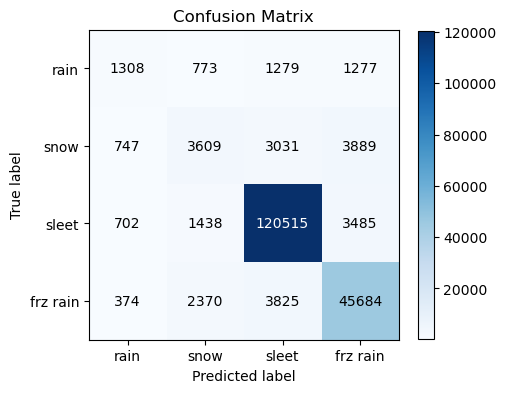

In [59]:
plot_confusion_matrix(test_data["true_label"], 
                      test_data["pred_label"], 
                      ["rain", "snow", "sleet", "frz rain"], 
                      "MLP", 
                      axis=-1)

plt.show()

### The Recieving Operator Curve (ROC) / area under the ROC (AUC)

In [67]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_auc(y_true, y_probabilities, classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probabilities[:, i])
        roc_auc[i] = roc_auc_score(y_true[:, i], y_probabilities[:, i])

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC Curve ({classes[i]}, AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', color='gray', lw=2, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc='best')
    plt.show()

/glade/derecho/scratch/schreck/tmp/ipykernel_12949/1313966077.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', lw=2, label='Random')


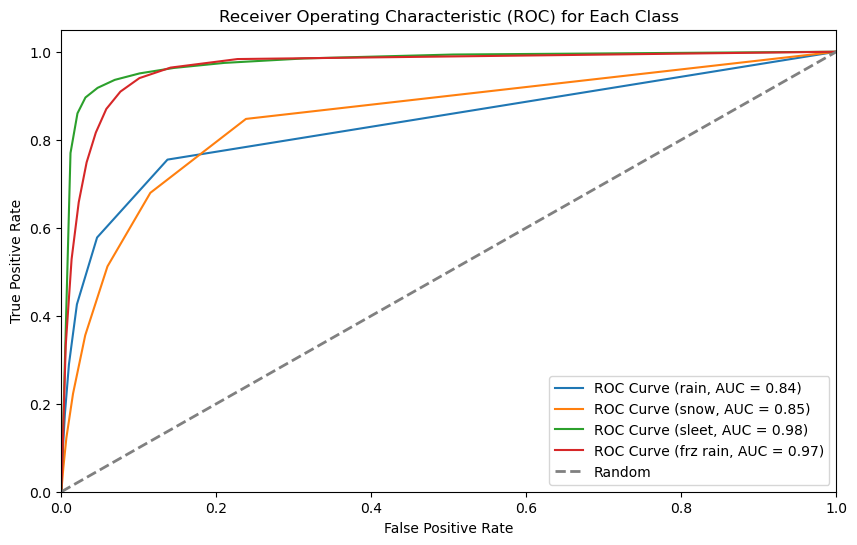

In [69]:
plot_roc_auc(y_test_hot, 
             pred_probs, 
             ["rain", "snow", "sleet", "frz rain"])

### Attributes (reliability) diagram

### If I have time CSI performance diagram